In [31]:
import subprocess
import os
import numpy as np

# Dependencies
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import zoom
from pyproj import Proj, Transformer
import rioxarray as rxr

In [2]:
# Setup filepaths
home_dir = os.path.expanduser('~')
username = os.path.basename(home_dir)
gdata_dir = os.path.join("/g/data/xe2", username)
scratch_dir = os.path.join('/scratch/xe2', username)
paddockTS_dir = os.path.join(home_dir, "Projects/PaddockTS")
print("username:", username)
print("home_dir:", home_dir)
print("gdata_dir:", gdata_dir)
print("scratch_dir:", scratch_dir)

username: cb8590
home_dir: /home/147/cb8590
gdata_dir: /g/data/xe2/cb8590
scratch_dir: /scratch/xe2/cb8590


In [3]:
# Local imports
os.chdir(paddockTS_dir)
from DAESIM_preprocess.slga_soils import create_bbox

In [4]:
# Choosing location
lat, lon = -34.3890427, 148.469499
buffer = 0.005  # 0.01 degrees is about 1km in each direction, so 2km total

stub = "MILG_1km"
outdir = os.path.join(gdata_dir, "Data/PadSeg/")
tmp_dir = os.path.join(scratch_dir, "tmp")

In [5]:
bbox = create_bbox(lat, lon, buffer)
bbox

[148.46449900000002, -34.3940427, 148.474499, -34.384042699999995]

In [18]:
def transform_bbox(bbox=[148.464499, -34.394042, 148.474499, -34.384042], inputEPSG="EPSG:4326", outputEPSG="EPSG:3857"):
    transformer = Transformer.from_crs(inputEPSG, outputEPSG)
    x1,y1 = transformer.transform(bbox[1], bbox[0])
    x2,y2 = transformer.transform(bbox[3], bbox[2])
    return (x1, y1, x2, y2)

bbox_3857 = transform_bbox()
bbox_3857

(16526992.42955847,
 -4081835.7602158766,
 16528105.624466406,
 -4080486.7952851765)

In [22]:
def run_gdalwarp(bbox=[148.464499, -34.394042, 148.474499, -34.3840426], filename="output.tif"):
    """Use gdalwarp to download a tif from terrain tiles"""

    if os.path.exists(filename):
        os.remove(filename)
    
    xml="DAESIM_preprocess/terrain_tiles.xml"
        
    bbox_3857 = transform_bbox(bbox)
    min_x, min_y, max_x, max_y = bbox_3857
    command = [
        "gdalwarp",
        "-of", "GTiff",
        "-te", str(min_x), str(min_y), str(max_x), str(max_y),
        xml, filename
    ]
    result = subprocess.run(command, capture_output=True, text=True)
    # print("STDOUT:", result.stdout, flush=True)
    # print("STDERR:", result.stderr, flush=True)
    print(f"Downloaded {filename}")

run_gdalwarp()

Downloaded output.tif


In [41]:
def interpolate_nan(filename="output.tif"):
    """Fix bad measurements in terrain tiles dem"""

    # Load the tiff into a numpy array rasterio
    with rasterio.open(filename) as dataset:
        dem = dataset.read(1) 
        meta = dataset.meta.copy()
    
    # There are some clearly bad measurements in terrain tiles and this attempts to assign them np.nan.
    threshold = 10
    heights = sorted(set(dem.flatten()))
    lowest_correct_height = min(heights)
    for i in range(len(heights)//2, -1, -1):
        if heights[i + 1] - heights[i] > threshold:
            lowest_correct_height = heights[i + 1] 
            break
    Z = np.where(dem < lowest_correct_height, np.nan, dem)
    
    # Extract into lists for interpolating
    x_coords, y_coords = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))
    x_flat = x_coords.flatten()
    y_flat = y_coords.flatten()
    z_flat = Z.flatten()
    
    # Remove NaN values before interpolating
    mask = ~np.isnan(z_flat)
    x_flat = x_flat[mask]
    y_flat = y_flat[mask]
    z_flat = z_flat[mask]
    xy_coords = np.vstack((x_flat, y_flat), dtype=float).T
    
    # Replace bad/nan/missing values with the nearest neighbour
    X, Y = np.meshgrid(np.linspace(0, Z.shape[1] - 1, Z.shape[1]),
                np.linspace(0, Z.shape[0] - 1, Z.shape[0]))
    nearest = griddata(xy_coords, z_flat, (X, Y), method='nearest')

    return dem, meta

dem, meta = interpolate_nan()
dem.shape

(282, 233)

In [37]:
def downsample(dem):
    """Downsample from 10m dem to 30m dem"""
    zoomed = zoom(dem, 1/3, order=0) 
    return zoomed

downsampled = downsample(dem)
downsampled.shape

(94, 78)

In [42]:
def download_dem(dem, meta, filename="terrain_tiles.tif"):
    meta.update({
        "driver": "GTiff",
        "height": dem.shape[0],
        "width": dem.shape[1],
        "count": 1,  # Number of bands
        "dtype": dem.dtype
    })
    with rasterio.open(filename, 'w', **meta) as dst:
        dst.write(dem, 1)
    print(f"Saved {filename}")

download_dem(dem, meta)

Saved terrain_tiles.tif


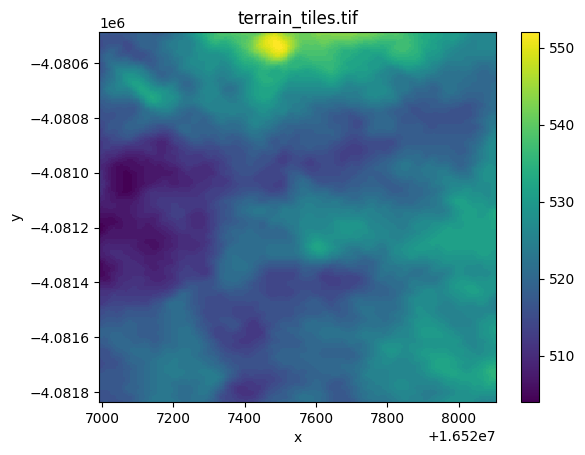

In [51]:
def visualise_tif(filename="terrain_tiles.tif"):
    ds = rxr.open_rasterio("terrain_tiles.tif")
    band = ds.sel(band=1)
    band.plot()
    plt.title(filename)
    plt.show()

visualise_tif()

In [ ]:
def terrain_tiles(lat, lon, buffer, outdir, stub):
    """Download 10m resolution elevation from terrain_tiles"""